# Setup

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ESA-Datalabs/XAMI-model/blob/main/dataset_and_model.ipynb)

In [1]:
import sys
import os

if 'google.colab' in sys.modules:
    !pip install -q condacolab
    import condacolab
    condacolab.install()

In [2]:
# skip this step if the package already exists
!git clone https://github.com/ESA-Datalabs/XAMI-model.git
os.chdir("XAMI-model")
!conda env update -n base -f environment.yaml
!pip install -e .

Cloning into 'XAMI-model'...
remote: Enumerating objects: 1139, done.
remote: Counting objects: 100% (238/238), done.
remote: Compressing objects: 100% (98/98), done.
remote: Total 1139 (delta 139), reused 238 (delta 139), pack-reused 901
Receiving objects: 100% (1139/1139), 109.78 MiB | 21.16 MiB/s, done.
Resolving deltas: 100% (632/632), done.


## Download dataset

In [5]:
!git clone https://github.com/ESA-Datalabs/XAMI-dataset.git
!pip install -e XAMI-dataset/

Cloning into 'XAMI-dataset'...
remote: Enumerating objects: 235, done.
remote: Counting objects: 100% (235/235), done.
remote: Compressing objects: 100% (180/180), done.
remote: Total 235 (delta 112), reused 172 (delta 52), pack-reused 0
Receiving objects: 100% (235/235), 2.30 MiB | 10.37 MiB/s, done.
Resolving deltas: 100% (112/112), done.
^C
You can inspect what was checked out with 'git status'
and retry with 'git restore --source=HEAD :/'


Exiting because of "interrupt" signal.



KeyboardInterrupt



In [ ]:
# in colab, there is an issue with recognizing these packages 
if 'google.colab' in sys.modules: 
  sys.path.append(os.getcwd())
  sys.path.append(os.path.join(os.getcwd(), 'XAMI-dataset'))

In [2]:
from xami_dataset.loader import XAMIDataset

# Download the dataset
xami_dataset = XAMIDataset(
    repo_id="iulia-elisa/XAMI-dataset",
    dataset_name="xami_dataset",
    dest_dir='./data_2')

xami_dataset.zip:   0%|          | 0.00/50.8M [00:00<?, ?B/s]

Dataset downloaded.
Dataset unzipped.
Train annotations file: ./data_2/xami_dataset/train/_annotations.coco.json
Valid annotations file: ./data_2/xami_dataset/valid/_annotations.coco.json


In [3]:
from xami_dataset.xami_utils import coco_to_yolo_converter

convert = True # if True, converts coco dataset to yolo format

if convert: 
    coco_to_yolo_converter.convert_coco_to_yolo(
    dir_absolute_path=os.getcwd(),
    dataset_path='./data_2/xami_dataset/',
    yolo_dataset_path=os.path.join(os.getcwd(), 'data_2/xami_dataset_YOLO')
)

Processed 790 files.
Processed 264 files.
YAML file /workspace/raid/OM_DeepLearning/XAMI-model/data_2/xami_dataset_YOLO/data.yaml created and saved.


## Download model weights

In [17]:
from huggingface_hub import hf_hub_download

dest_dir = './xami_model/train/weights/'
checkpoints = [
    'yolo_weights/yolov8_detect_300e_best.pt', 
    'yolo_weights/yolov8_detect_300e_last.pt', \
    'sam_weights/sam_0_best.pth', 
    'sam_weights/original_mobile_sam.pt', 
    'yolo_sam_final.pth']

# download checkpoints from HuggingFace
for checkpoint in checkpoints:
    hf_hub_download(
    			repo_id="iulia-elisa/XAMI-model",
    			repo_type='model',
    			filename=checkpoint,
    			local_dir=dest_dir
    		)
print(f'Checkpoints saved in {dest_dir}')

original_mobile_sam.pt:   0%|          | 0.00/40.7M [00:00<?, ?B/s]

Checkpoints saved in ./xami_model/train/weights/


# Inference

In [1]:
from xami_model.inference.xami_inference import InferXami

detr_checkpoint = './xami_model/train/weights/yolo_weights/yolov8_detect_300e_last.pt'
sam_checkpoint = './xami_model/train/weights/sam_weights/sam_0_best.pth'

#❗️the SAM checkpoint and model_type (vit_h, vit_t, etc.) must be compatible
#❗️the detr_type and its checkpoints must be compatible
detr_sam_pipeline = InferXami(
    device='cuda:2',
    detr_checkpoint=detr_checkpoint,
    sam_checkpoint=sam_checkpoint,
    model_type='vit_t',
    use_detr_masks=True,
    detr_type='yolo') # 'rt-detr' or 'yolo'

Initializing the model...
Using YOLO masks for faint (1sigma) sources.


Warming up SAM model: 100%|██████████| 3/3 [00:00<00:00,  7.07it/s]                                                                  


In [2]:
# masks = detr_sam_pipeline.run_predict('./example_images/S0893811101_M.png', show_masks=True)

Number of object detected: 7
   other
   star-loop


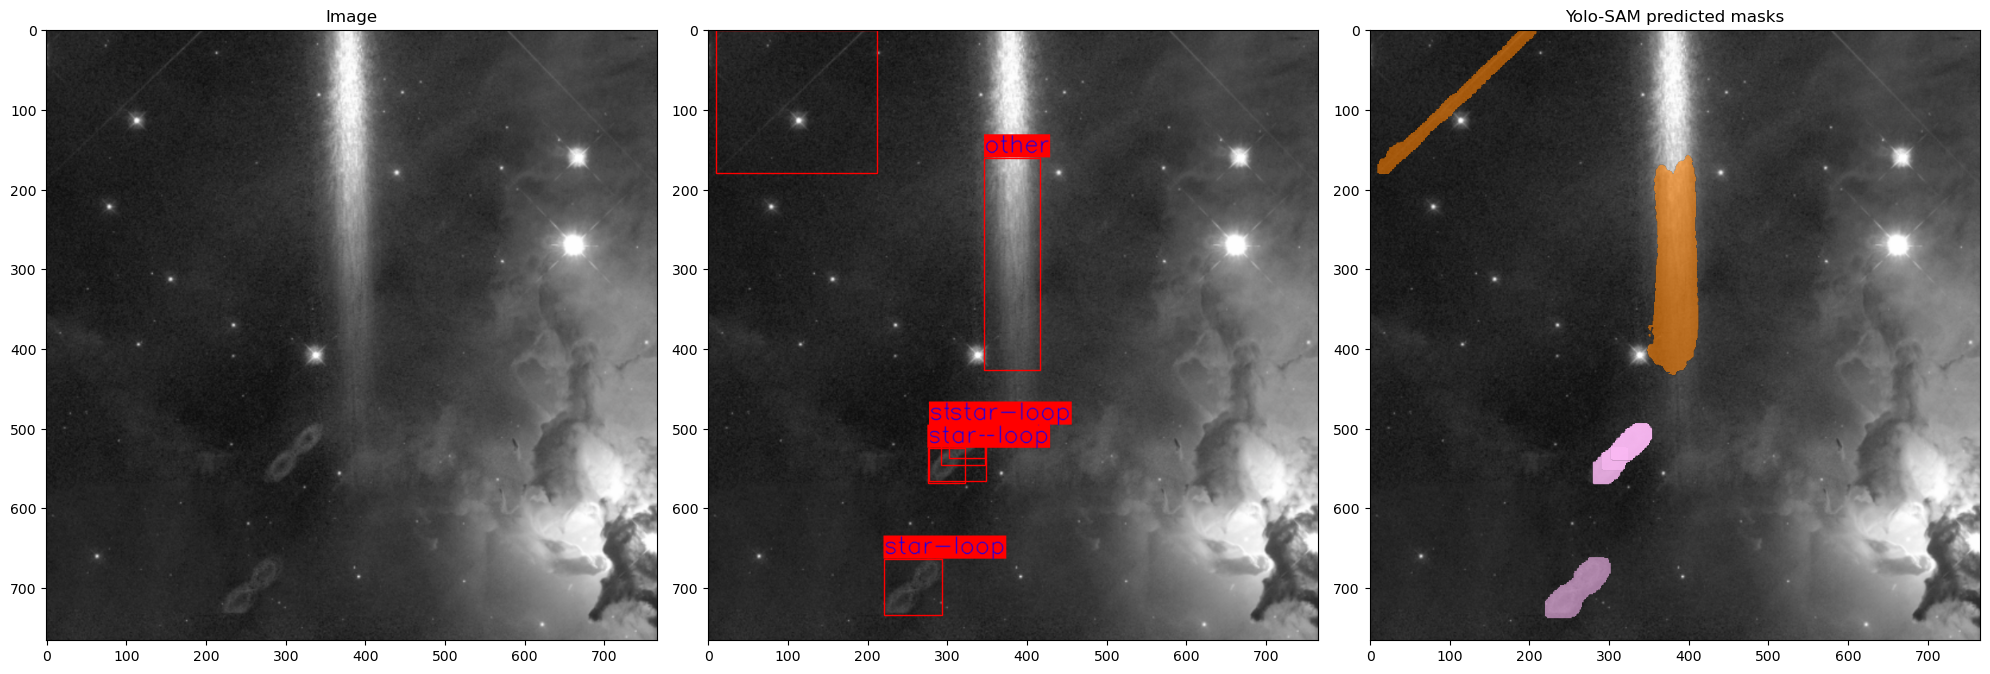

In [3]:
masks = detr_sam_pipeline.run_predict('./example_images/hubble_artefacts.png', show_masks=True)

Number of object detected: 3
   read-out-streak
   star-loop


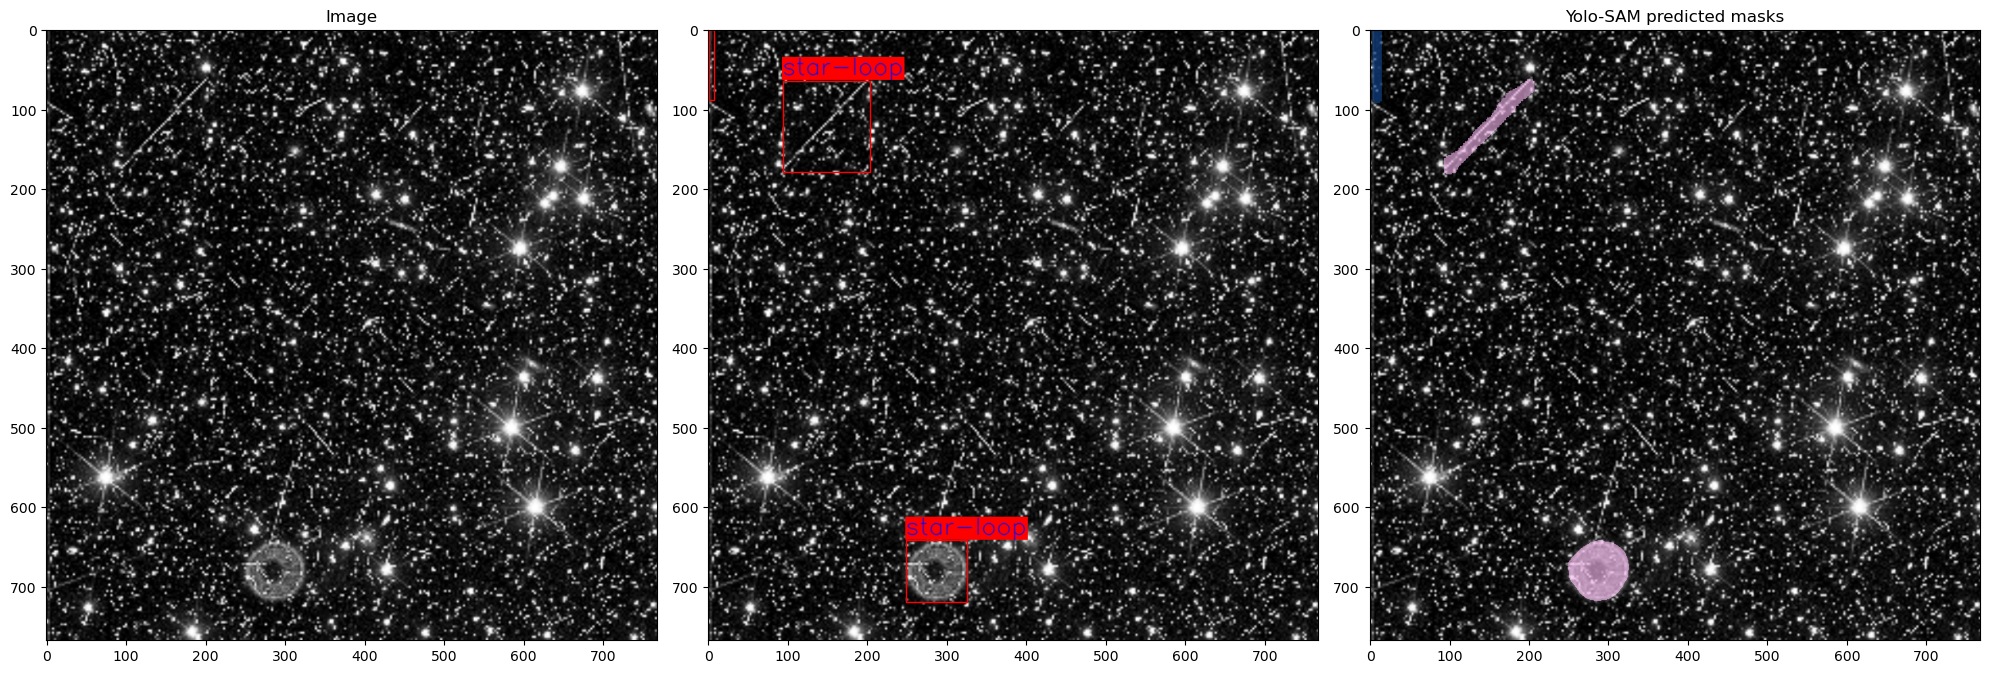

In [4]:
masks = detr_sam_pipeline.run_predict('./example_images/euclid_artefacts.png', show_masks=True)